In [99]:
import os.path as osp
import sys
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

sys.path.append("../src")
from architecture_utils import LinearNet
from main_low_rank_regression import calc_effective_rank


def get_values_from_list_of_dict(d_list, key):
    return [d[key] for d in d_list]

In [111]:
# Load
input_dir = osp.join("../output", "low_rank_regression_20210630_105640") # low_rank_regression_20210630_151441 bottelneck 
csv_path = osp.join(input_dir, "results.csv")
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,n_train,theta_mn,mse_test_net,mse_test_mn,mse_train_net,mse_train_mn,input_size,output_size,intermediate_sizes
0,0,10,"[[0.06298562869540147], [-0.2150127402960511],...",3.997353e-05,2.766449e-05,5.726511e-14,1.927704e-25,101,1,"[102, 76, 26]"
1,1,25,"[[0.5431092902677523], [-0.18194845045326957],...",3.360882e-06,3.110023e-06,8.604018e-10,1.051350e-20,101,1,"[102, 76, 26]"
2,2,41,"[[-0.11798915499137053], [-0.06794892067143365...",1.266271e-06,9.205852e-07,1.187705e-08,1.369876e-20,101,1,"[102, 76, 26]"
3,3,56,"[[0.02526786329645958], [0.13500360501624087],...",6.481253e-07,5.614535e-07,3.622881e-08,4.185681e-20,101,1,"[102, 76, 26]"
4,4,71,"[[0.17770618221275924], [-0.13986053618339156]...",4.670298e-07,2.239391e-07,3.972488e-08,8.812480e-19,101,1,"[102, 76, 26]"


In [112]:
theta_star = torch.load(osp.join(input_dir, "theta_star.pth"))
theta_star_norm = torch.norm(theta_star)
x_train, y_train, x_test, y_test = torch.load(osp.join(input_dir, "dataset.pth"))

In [113]:
weight_dicts = []
for i, row in df.iterrows():
    n_train = row["n_train"]
    net = LinearNet(
        input_size=row["input_size"],
        output_size=row["output_size"],
        intermediate_sizes=eval(row["intermediate_sizes"]),
    )
    net.load_state_dict(
        torch.load(osp.join(input_dir, "net_n_train={}.pth".format(n_train)))
    )

    weights = [layer.weight for layer in net.layers]

    w = weights[-1]
    weights_to_mul = weights[:-1]
    for w_i in weights_to_mul[::-1]:
        w = w @ w_i

    theta_mn = torch.tensor(eval(row["theta_mn"]))
    weight_dict = {
        "w": w,
        "norm": torch.norm(w),
        "mn_norm": torch.norm(theta_mn),
        "n_train": row["n_train"],
        "effective_ranks": [
            calc_effective_rank(torch.linalg.svd(w_i)[1]).item() for w_i in weights
        ],
        "weights": weights,
    }
    weight_dicts.append(weight_dict)

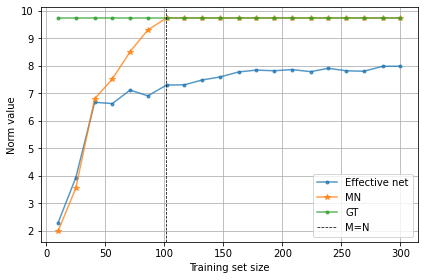

In [114]:
n_trains = get_values_from_list_of_dict(weight_dicts, "n_train")
norms = get_values_from_list_of_dict(weight_dicts, "norm")
mn_norms = get_values_from_list_of_dict(weight_dicts, "mn_norm")


fig, ax = plt.subplots(1, 1)
ax.plot(n_trains, norms, label="Effective net", marker=".", alpha=0.75)
ax.plot(n_trains, mn_norms, label="MN", marker="*", alpha=0.75)
ax.plot(n_trains, [theta_star_norm] * len(n_trains), marker=".", label="GT", alpha=0.75)
ax.axvline(df.input_size[0], label="M=N", color="black", linestyle="--", linewidth=0.75)
# ax.set_yscale('log')

ax.set_xlabel("Training set size")
ax.set_ylabel("Norm value")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

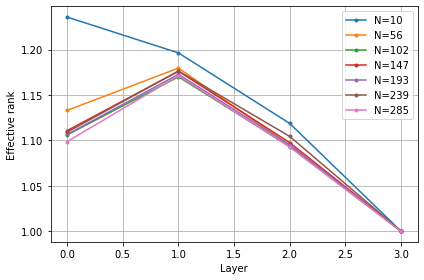

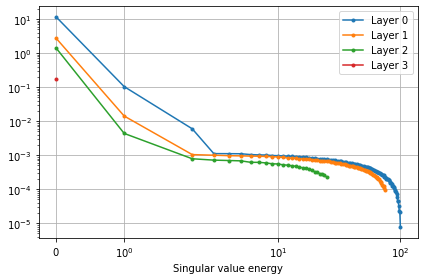

In [115]:
fig, ax = plt.subplots(1, 1)
for n, weight_dict in enumerate(weight_dicts[::3]):
    ax.plot(
        weight_dict["effective_ranks"],
        "-",
        marker=".",
        label="N={}".format(weight_dict["n_train"]),
    )

ax.legend()
ax.set_xlabel("Layer")
ax.set_ylabel("Effective rank")
ax.grid()
plt.tight_layout()
plt.show()

for i, weight in enumerate(weights):
    plt.plot(torch.svd(weight)[1].detach().numpy(), "-", marker=".", label=f"Layer {i}")
plt.xlabel("Singular value index")
plt.xlabel("Singular value energy")
plt.xscale("symlog")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

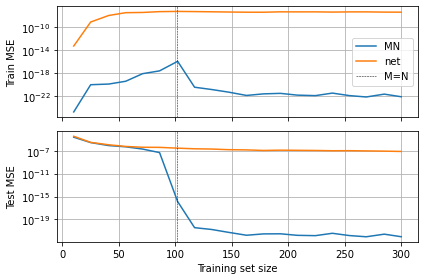

In [116]:
fig, axs = plt.subplots(2, 1, sharex=True)

ax = axs[0]
ax.plot(df.n_train, df.mse_train_mn, label="MN")
ax.plot(df.n_train, df.mse_train_net, label="net")
ax.axvline(df.input_size[0], label="M=N", color="black", linestyle="--", linewidth=0.5)
ax.set_ylabel("Train MSE")
ax.set_yscale("log")
ax.grid()
ax.legend()

ax = axs[1]
ax.plot(df.n_train, df.mse_test_mn, label="MN")
ax.plot(df.n_train, df.mse_test_net, label="net")
ax.axvline(df.input_size[0], label="M=N", color="black", linestyle="--", linewidth=0.5)
ax.set_ylabel("Test MSE")
ax.set_xlabel("Training set size")
ax.set_yscale("log")
ax.grid()


plt.tight_layout()
plt.show()

## Reconstructing th net

In [107]:
x_train_i, y_train_i = x_train[:n_train].double(), y_train[:n_train].double()

net.double()
y_hat = x_test @ w.T.double()
mse_net_test = torch.mean((y_hat - y_test) ** 2).item()

features = []
feature_l = x_train_i
for layer in net.layers:
    feature_l = layer(feature_l)
    features.append(feature_l.clone())
for feature_l in features:
    print(feature_l.shape)

print("reconstructing theta")
thetas = []
features.insert(0, x_train_i)
features[-1] = y_train_i
for l in range(1, len(features)):
    x_tilde = features[l - 1]
    y_tilde = features[l]
    theta_l = torch.linalg.inv(x_tilde.T @ x_tilde) @ x_tilde.T @ y_tilde
    print(theta_l.shape)
    thetas.append(theta_l)

torch.Size([300, 101])
torch.Size([300, 101])
torch.Size([300, 101])
torch.Size([300, 1])
reconstructing theta
torch.Size([101, 101])
torch.Size([101, 101])
torch.Size([101, 101])
torch.Size([101, 1])


In [108]:
theta_effective = thetas[0]
theta = thetas[-1].T
thetas_to_mul = thetas[:-1]
for theta_l in thetas_to_mul[::-1]:
    theta = theta @ theta_l.T
theta = theta.T

In [109]:
y_hat = x_test @ theta
mse_net_reconstructed_test = torch.mean((y_hat - y_test) ** 2).item()

y_hat = x_test @ torch.linalg.inv(x_train_i.T @ x_train_i) @ x_train_i.T @ y_train_i
mse_mn = torch.mean((y_hat - y_test) ** 2).item()
mse_net_reconstructed_test, mse_net_test, mse_mn

(208.27017016134005, 8.593183093109616e-08, 8.333842941692644e-23)

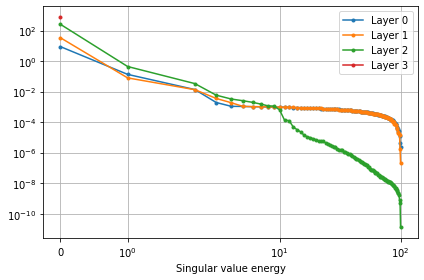

In [110]:
for i, theta_l in enumerate(thetas):
    plt.plot(
        torch.svd(theta_l)[1].detach().numpy(), "-", marker=".", label=f"Layer {i}"
    )
# for i, weight in enumerate(weights):
#     plt.plot(torch.svd(weight)[1].detach().numpy(), "-", marker=".", label=f"Layer {i}")
plt.xlabel("Singular value index")
plt.xlabel("Singular value energy")
plt.xscale("symlog")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()